## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import time
import datetime

In [3]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [4]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [5]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [6]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


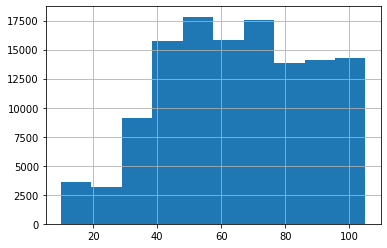

In [7]:
df_transactions['tran_amount'].hist()

In [8]:
df_transactions['ts'] = df_transactions.trans_date.values.astype(np.int64) // 10 ** 9
# df_transactions['ts'] = pd.Timestamp(df_transactions['trans_date'])
#ts = timestamp
print(df_transactions)

       customer_id trans_date  tran_amount          ts
0           CS5295 2013-02-11           35  1360540800
1           CS4768 2015-03-15           39  1426377600
2           CS2122 2013-02-26           52  1361836800
3           CS1217 2011-11-16           99  1321401600
4           CS1850 2013-11-20           78  1384905600
...            ...        ...          ...         ...
124995      CS8433 2011-06-26           64  1309046400
124996      CS7232 2014-08-19           38  1408406400
124997      CS8731 2014-11-28           42  1417132800
124998      CS8133 2013-12-14           13  1386979200
124999      CS7996 2014-12-13           36  1418428800

[125000 rows x 4 columns]


In [9]:
#Timestamp at 01 Jan 2013 00.00.00 is 1356973200
#Timestamp at 01 Jan 2014 00.00.00 is 1388509200

In [10]:
# scoping data to be more recent : from 2013 to 2015
# dfx = df_transactions['ts'] > 1356973200
# print(dfx)
df_transactions = df_transactions.drop(df_transactions[df_transactions.ts < 1388509200].index)

print(df_transactions)

       customer_id trans_date  tran_amount          ts
1           CS4768 2015-03-15           39  1426377600
5           CS5539 2014-03-26           81  1395792000
7           CS5902 2015-01-30           89  1422576000
14          CS5552 2014-12-29           78  1419811200
15          CS6043 2014-01-15           98  1389744000
...            ...        ...          ...         ...
124990      CS8960 2014-07-04           39  1404432000
124991      CS8076 2014-05-16           68  1400198400
124996      CS7232 2014-08-19           38  1408406400
124997      CS8731 2014-11-28           42  1417132800
124999      CS7996 2014-12-13           36  1418428800

[38897 rows x 4 columns]


## **Data Preparation**

In [11]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,ts,recent
1,CS4768,2015-03-15,39,1426377600,2.0
5,CS5539,2014-03-26,81,1395792000,356.0
7,CS5902,2015-01-30,89,1422576000,46.0
14,CS5552,2014-12-29,78,1419811200,78.0
15,CS6043,2014-01-15,98,1389744000,426.0


In [12]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [13]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,4,251
1,CS1113,36.0,7,446
2,CS1114,33.0,7,504
3,CS1115,12.0,5,368
4,CS1116,204.0,5,333


In [14]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [15]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,4,251,260,62.750000
1,CS1113,36.0,7,446,398,63.714286
2,CS1114,33.0,7,504,383,72.000000
3,CS1115,12.0,5,368,420,73.600000
4,CS1116,204.0,5,333,199,66.600000


## **Calculating response rate**

In [16]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


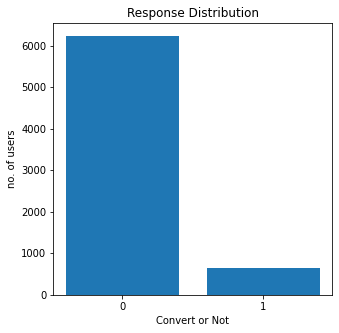

In [17]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [18]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,4,251
1,CS1113,0,36.0,7,446
2,CS1114,1,33.0,7,504
3,CS1115,1,12.0,5,368
4,CS1116,1,204.0,5,333


In [19]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,4,251,260,62.750000
1,CS1113,0,36.0,7,446,398,63.714286
2,CS1114,1,33.0,7,504,383,72.000000
3,CS1115,1,12.0,5,368,420,73.600000
4,CS1116,1,204.0,5,333,199,66.600000


## **Creating train and test dataset**

In [20]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [21]:
## creating train and test dataset
# change test_size 0.3=>0.7

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.7, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.7, random_state=0)

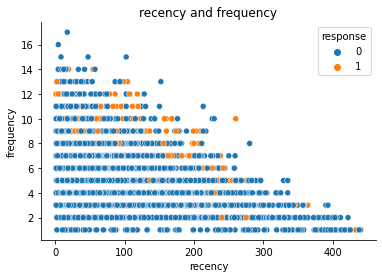

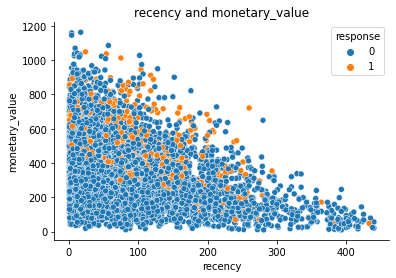

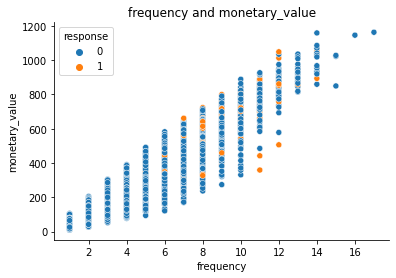

In [22]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

In [23]:
print(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']])

      recency  frequency  monetary_value  AOU  ticket_size
0        62.0          4             251  260    62.750000
1        36.0          7             446  398    63.714286
2        33.0          7             504  383    72.000000
3        12.0          5             368  420    73.600000
4       204.0          5             333  199    66.600000
...       ...        ...             ...  ...          ...
6841     98.0          6             336  118    56.000000
6842    262.0          2              84  127    42.000000
6843     85.0          4             130  153    32.500000
6844    258.0          2              42   98    21.000000
6845     17.0          5             131  412    26.200000

[6846 rows x 5 columns]


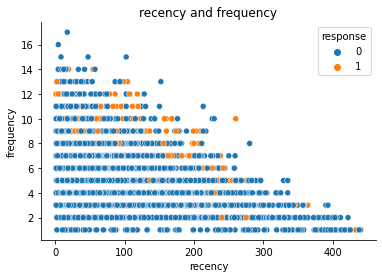

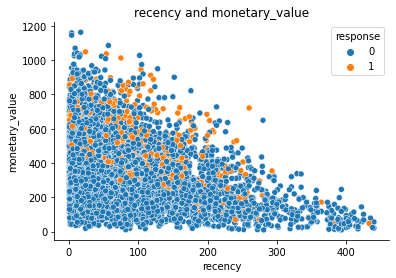

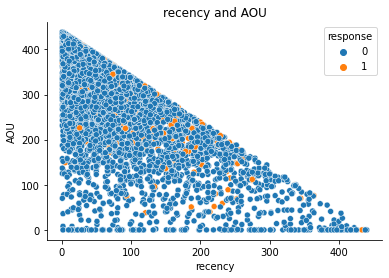

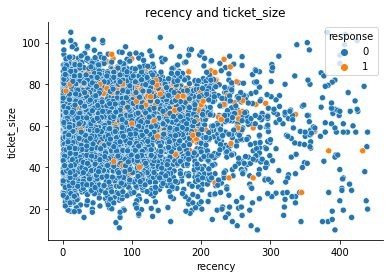

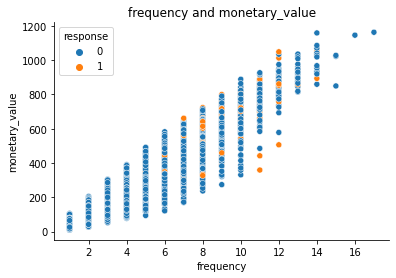

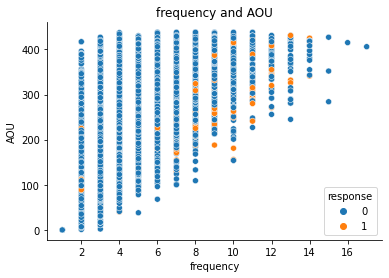

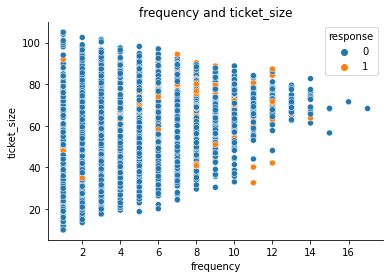

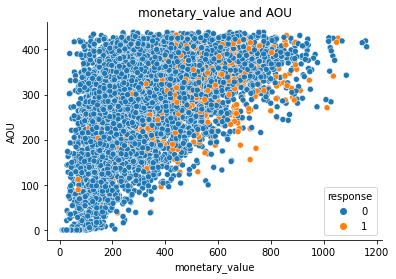

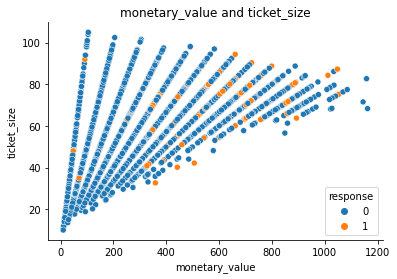

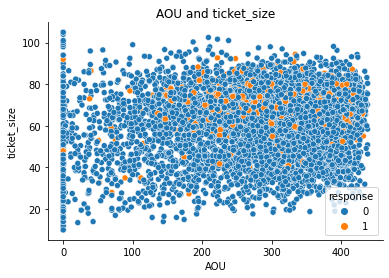

In [24]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    # print(f'{i}-----{j}')
    if i < j :
      # print(f'{col_i}----{col_j}')
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [25]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_sample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

In [26]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      1871
           1       0.68      0.72      0.70      1871

    accuracy                           0.69      3742
   macro avg       0.69      0.69      0.69      3742
weighted avg       0.69      0.69      0.69      3742

test set
              precision    recall  f1-score   support

           0       0.95      0.67      0.78      4328
           1       0.18      0.67      0.28       465

    accuracy                           0.67      4793
   macro avg       0.56      0.67      0.53      4793
weighted avg       0.87      0.67      0.74      4793



In [27]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.72      0.67      0.69      1871
           1       0.69      0.74      0.71      1871

    accuracy                           0.70      3742
   macro avg       0.70      0.70      0.70      3742
weighted avg       0.70      0.70      0.70      3742

test set
              precision    recall  f1-score   support

           0       0.95      0.66      0.78      4328
           1       0.18      0.68      0.28       465

    accuracy                           0.66      4793
   macro avg       0.56      0.67      0.53      4793
weighted avg       0.88      0.66      0.73      4793



## **XGBoost**

In [28]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.5, #change .01=> .5
 n_estimators=100,
 max_depth=10,#change 2=> 10
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.581259
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.66687
[2]	validation_0-auc:0.660372
[3]	validation_0-auc:0.654867
[4]	validation_0-auc:0.68053
[5]	validation_0-auc:0.689949
[6]	validation_0-auc:0.68526
[7]	validation_0-auc:0.693387
[8]	validation_0-auc:0.691508
[9]	validation_0-auc:0.698393
[10]	validation_0-auc:0.703537
[11]	validation_0-auc:0.704843
[12]	validation_0-auc:0.705624
[13]	validation_0-auc:0.705592
[14]	validation_0-auc:0.701971
[15]	validation_0-auc:0.703378
[16]	validation_0-auc:0.704289
[17]	validation_0-auc:0.702937
Stopping. Best iteration:
[12]	validation_0-auc:0.705624

training set
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1871
           1       0.94      0.94      0.94      1871

    accuracy                           0.94      3742
   macro avg       0.94      0.94      0.94      3742
weighted avg       0.94

In [29]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.5, #change .01=> .5
 n_estimators=100,
 max_depth=10,#change 2=> 10
 gamma=0.0,
 colsample_bytree=0.6)

#best params: clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 300, 'fs__k': 2,

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.646676
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.676368
[2]	validation_0-auc:0.678955
[3]	validation_0-auc:0.688053
[4]	validation_0-auc:0.690764
[5]	validation_0-auc:0.69037
[6]	validation_0-auc:0.689296
[7]	validation_0-auc:0.688623
[8]	validation_0-auc:0.688292
[9]	validation_0-auc:0.690573
Stopping. Best iteration:
[4]	validation_0-auc:0.690764

training set
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1871
           1       0.94      0.96      0.95      1871

    accuracy                           0.95      3742
   macro avg       0.95      0.95      0.95      3742
weighted avg       0.95      0.95      0.95      3742

test set
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      4328
           1       0.18      0.26      0.21       465

    accuracy                           0.8

In [30]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [31]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {   #clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 300, 'fs__k': 2,
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10 for i in range(4, 5)], #change range (4,7) => (4.4)
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=50) #Random state from 42 =>50
# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score), 'F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   17.0s finished


In [32]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test_clv, predictions)))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7720679007189519
Accuracy: 0.6951804715209681
[[3033 1295]
 [ 166  299]]
test set
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      4328
           1       0.19      0.64      0.29       465

    accuracy                           0.70      4793
   macro avg       0.57      0.67      0.55      4793
weighted avg       0.87      0.70      0.76      4793



In [33]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 300, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7f14e12460e0>}
